<center><img src="img/logo_hse_black.jpg"></center>

<h1><center>Data Analysis</center></h1>
<h2><center>Seminar: Ensemble Learning. </center></h2>

In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Read Data

In [0]:
df_X = pd.read_csv('./data/x_train.csv', sep=';')
df_y = pd.read_csv('./data/y_train.csv', sep=';', header=None, names=['target'])

In [0]:
X = df_X.values
y = df_y['target'].values

In [9]:
print("X shape: ", X.shape)
X[:5]

X shape:  (25289, 12)


array([[3.90000000e+01, 1.00000000e+01, 3.00000000e+00, 1.70000000e+01,
        2.44444444e+01, 1.00000000e+00, 5.00000000e+00, 4.00000000e-01,
        2.65000000e+06, 1.37500000e+03, 2.10000000e+01, 2.00000000e+00],
       [2.10000000e+01, 2.20000000e+01, 1.90000000e+01, 5.50000000e+01,
        1.70454545e+01, 1.00000000e+00, 6.00000000e+00, 3.33333333e-01,
        5.61400000e+06, 3.82500000e+03, 5.10000000e+01, 4.00000000e+00],
       [5.00000000e+00, 6.00000000e+00, 1.00000000e+00, 6.00000000e+00,
        8.40000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        8.57000000e+05, 1.15000000e+03, 1.40000000e+01, 1.00000000e+00],
       [2.10000000e+01, 2.00000000e+00, 5.00000000e+00, 6.00000000e+00,
        1.90000000e+01, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        1.20000000e+05, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [4.00000000e+00, 5.00000000e+00, 1.00000000e+00, 5.00000000e+00,
        9.60000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00

In [10]:
print("y shape: ", y.shape)
y[:5]

y shape:  (25289,)


array([0, 1, 1, 1, 0])

# Train / Test Split

In [0]:
# import train_test_split function to split the sample
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.5,    
                                                    random_state=123) 

# Task 1 (5 points)

Implement Random Forest classifier as it was described in your lectures:

**Input**: 
* training dataset $TDS=\{(x_{i},y_{i}),\,1=1,2,...N\}$; 
* the number of trees $B$ and the size of feature subsets $m$.

for $b=1,2,...B$:

1. generate random training dataset $TDS^{b}$ of size $N$ by sampling $(x_{i},y_{i})$ pairs from $TDS$ with replacement (bootstrap)
2. build a tree using $TDS^{b}$ training dataset with feature selection for each node from random subset of features of size $m$ (generated **individually for each node**).


**Output**: $B$ trees. Classification is done using majority vote and regression using averaging of $B$ outputs

**Hints:**
- Use decision tree classifier from sklean library. You can import it with the command: `from sklearn.tree import DecisionTreeClassifier` with `max_features` option. 
- You can use `numpy.random.choice()` function to generate random subsamples to train decition tree classifiers.

### Let' s start with small steps

#### First step

Implement auxiliary function, which generate K random subsamples (with replacement) of X, y of size N

In [0]:
def gen_subsamples(X, y, K, N):
    indexes = range(X.shape[0])
    subsamples = []

    for i in range(K):
        sub_ind = np.random.choice(indexes, size=N, replace=True)
        X_subsamples = X[sub_ind]
        y_subsamples = y[sub_ind]
        subsamples.append((X_subsamples, y_subsamples))
        
    return subsamples

#### Second step

Implement auxiliary function which get list of (X,y) with lengh K and fit K base_estimators. Each estimator fit from the corresponding sample. 

In [0]:
def fit_subsamples(subsamples, base_estimator):
    fitted_estimates = []
    
    for i in range(len(subsamples)):
        est = base_estimator()
        est.fit(subsamples[i][0], subsamples[i][1])
        fitted_estimates.append(est)
        
    return fitted_estimates

#### Example with multiprocessing

In [0]:
def fit(params):    
    from sklearn.tree import DecisionTreeClassifier
    X, y, size = params
    subsamples = gen_subsamples(X, y, size, X.shape[0])
    return fit_subsamples(subsamples, DecisionTreeClassifier)

In [0]:
import multiprocessing

process_count = 4
parts = [
   (X, y, 1000 // process_count) for i in range(process_count)
]

In [0]:
with multiprocessing.Pool(process_count) as p:
    # every part is sent to separate processes
    clfs = p.map(fit, parts)

### And now combine it all together in one class

In [0]:
from sklearn.tree import DecisionTreeClassifier

In [0]:
# You need to modify this class #

class RandomForestClassifier(object):
    
    def __init__(self, n_trees=10, n_subset_features=2): # you can add more hyperparameters
        """
        This is your random forest classifier.
        
        Parameters
        ----------
        n_trees : int
            Number of decision trees to train.
        n_subset_features : int
            Number of random features to used to train a decision tree.
        """
        
        self.n_trees = n_trees
        self.n_subset_features = n_subset_features
        self.estimators = []
       
    def fit_subsample(self, params):
        X, y = params
        clf = DecisionTreeClassifier(max_features=self.n_subset_features)
        clf.fit(X, y)
        return clf
        
        
    def fit(self, X, y):
        """
        Fit the classifier.
        
        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
        y : numpy.array, shape = (n_objects)
            1D array with the object labels. 
            For the classification labels are integers in {0, 1, 2, ...}.
        """
        subsamples = gen_subsamples(X, y, self.n_trees, X.shape[0])
        
        with multiprocessing.Pool(self.n_trees) as p:
            self.estimators = p.map(self.fit_subsample, subsamples)
        
    
    def predict_proba(self, X):
        """
        This methods performs probabilities prediction for new objects.
        
        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
            
        Returns
        -------
        proba : numpy.array, shape = (n_objects, n_classes)
            Array with predicted probabilities. 
        """
        probas = []
        
        for i in range(self.n_trees):
            probas.append(self.estimators[i].predict_proba(X))
        
        probas = np.array(probas)
        return probas.mean(axis=0)
    
    
    def predict(self, X):
        """
        This methods performs labels prediction for new objects.
        
        Parameters
        ----------
        X : numpy.array, shape = (n_objects, n_features)
            Matrix of objects that are described by their input features.
            
        Returns
        -------
        labels : numpy.array, shape = (n_objects)
            1D array with predicted labels. 
            For the classification labels are integers in {0, 1, 2, ...}.
        """
        
        predicts = []
        
        for i in range(self.n_trees):
            predicts.append(self.estimators[i].predict(X))
        
        predicts = np.array(predicts)
        prediction = 1. * (predicts.mean(axis=0) >= 0.5)
        
        return prediction

In [0]:
clf = RandomForestClassifier(n_trees=10, n_subset_features=2)
clf.fit(X_train, y_train)

In [101]:
y_test_predict = clf.predict(X_test)

y_test_predict[:10]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [0]:
 from sklearn.metrics import accuracy_score

In [87]:
accuracy_score(y_test_predict, y_test)

0.8040332147093713

# Task 2 (1 point)

Plot ROC curve on the test sample for your random forest classifier. Also, claculate ROC AUC value. Use `RandomForestClassifier.predict_proba()` method.

Hints:
- You can use `sklearn.metrics.roc_curve` frunction to calculate ROC curve.
- `sklearn.metrics.roc_auc_score` function helps you to calculate ROC AUC value.

In [0]:
from sklearn.metrics import roc_curve, roc_auc_score

In [129]:
y_test_probas_true = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_probas_true)

score = roc_auc_score(y_test, y_test_probas_true)
print("ROC-AUC Score: ", score)

ROC-AUC Score:  0.8439106166585144


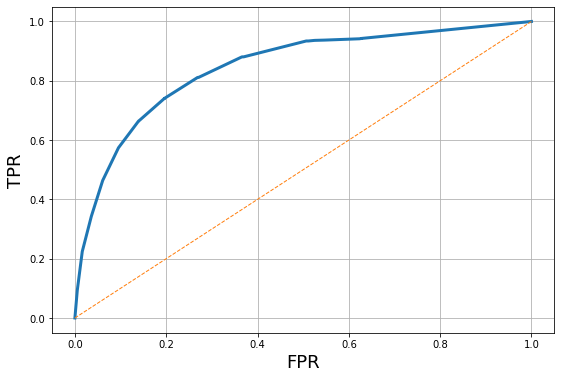

In [130]:
x, y = [0, 1], [0, 1]

plt.figure(figsize=(9, 6))
plt.plot(fpr, tpr, linewidth=3)
plt.plot(x, y, linewidth=1, linestyle='--')

plt.xlabel('FPR', size=18)
plt.ylabel('TPR', size=18)
plt.grid(b=1)
plt.show()

# Task 3 (2 points)

Plot dependecy of ROC AUC value from number of trees (`n_trees`) in your random forest classifier.

In [0]:
trees = range(1, 101)
scores = []

for v in trees:
  clf = RandomForestClassifier(n_trees=v, n_subset_features=2)
  clf.fit(X_train, y_train)
  probas = clf.predict_proba(X_test)[:, 1]
  scores.append(roc_auc_score(y_test, probas))

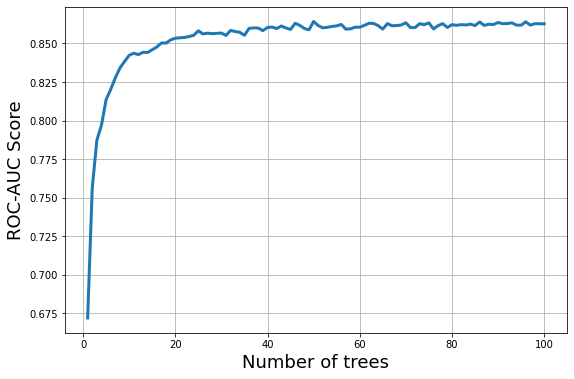

In [138]:
plt.figure(figsize=(9, 6))
plt.plot(trees, scores, linewidth=3)

plt.xlabel('Number of trees', size=18)
plt.ylabel('ROC-AUC Score', size=18)
plt.grid(b=1)
plt.show()

# Task 4 (2 points)

Plot dependecy of ROC AUC value from `n_subset_features` of your random forest classifier. Use `n_trees=100`.

In [0]:
subsets = range(1, X.shape[1])
scores = []

for v in subsets:
  clf = RandomForestClassifier(n_trees=100, n_subset_features=v)
  clf.fit(X_train, y_train)
  probas = clf.predict_proba(X_test)[:, 1]
  scores.append(roc_auc_score(y_test, probas))

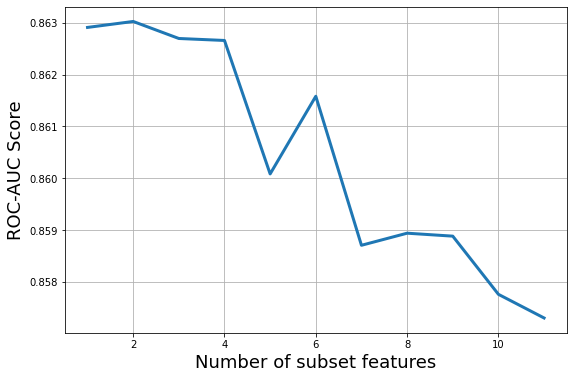

In [144]:
plt.figure(figsize=(9, 6))
plt.plot(subsets, scores, linewidth=3)

plt.xlabel('Number of subset features', size=18)
plt.ylabel('ROC-AUC Score', size=18)
plt.grid(b=1)
plt.show()